In [1]:
import os, sys

In [2]:
base_dir = os.path.split(os.getcwd())[0]
os.chdir(os.path.join(base_dir,'core'))

In [3]:
import pickle as pk

import numpy as np
import cv2
import sys
import argparse
import time
import copy
import datetime

import matplotlib.pyplot as plt

from utils import ARUCO_DICT, display_pose
from posesingle import PoseSingle

In [4]:
k_matrix = "../calib/calibration_matrix_hikvision.npy"
d_coeff = "../calib/distortion_coefficients_hikvision.npy"
m_dict = "../demo_tags/marker_poses.pk"
edge_len = 0.1645
marker_step = 2.095
n_markers = 4

type_ = "DICT_7X7_100"

if ARUCO_DICT.get(type_, None) is None:
    print(f"ArUCo tag type '{type_}' is not supported")
    sys.exit(0)

aruco_dict_type = ARUCO_DICT[type_]
calibration_matrix_path = k_matrix
distortion_coefficients_path = d_coeff
marker_dict_path = m_dict


k = np.load(calibration_matrix_path)
d = np.load(distortion_coefficients_path)

with open(marker_dict_path,'rb') as f:
    marker_dict = pk.load(f)

estimator = PoseSingle(aruco_dict_type,
                       n_markers,
                       marker_step,
                       edge_len,
                       k,
                       d)

before
det 0.9999999999999997
[[ 0.88593317  0.19521531 -0.4207296   0.32077508]
 [ 0.21028879 -0.97757984 -0.01078302 -0.21805054]
 [-0.41340179 -0.07892169 -0.907122    1.62015223]
 [ 0.          0.          0.          1.        ]]
after
det 0.9999999999999997
[[ 0.88593317  0.19521531 -0.4207296   0.32077508]
 [ 0.21028879 -0.97757984 -0.01078302 -0.21805054]
 [-0.41340179 -0.07892169 -0.907122    1.62015223]
 [ 0.          0.          0.          1.        ]]
before
det 1.000000000000001
[[ 0.85595497  0.19512142 -0.47882013 -1.53233492]
 [ 0.20064359 -0.97883899 -0.04020419 -0.62049709]
 [-0.47653251 -0.06165922 -0.87699196  2.75112039]
 [ 0.          0.          0.          1.        ]]
after
det 1.000000000000001
[[ 0.85595497  0.19512142 -0.47882013 -1.53233492]
 [ 0.20064359 -0.97883899 -0.04020419 -0.62049709]
 [-0.47653251 -0.06165922 -0.87699196  2.75112039]
 [ 0.          0.          0.          1.        ]]
before
det 1.0000000000000007
[[ 0.83861831  0.18892945 -0.51090

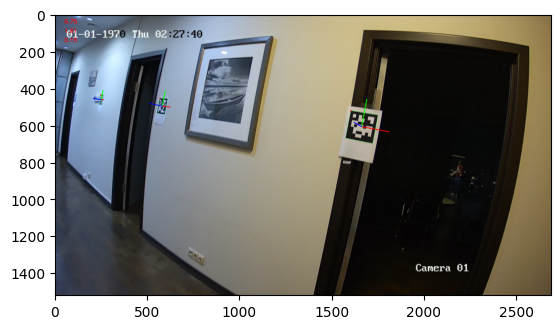

[[ 0.88268916  0.20931148 -0.42077138  6.74631359]
 [-0.42756297 -0.01395406 -0.90387786  1.6074119 ]
 [-0.19506348  0.97774945  0.07717674  0.14718206]
 [ 0.          0.          0.          1.        ]]


In [5]:
# Test on single image
image = "../data/hikvision/demo1/frames_r/3.png"

image = cv2.imread(image)
time.sleep(.1)

# output = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.imshow(output)
# plt.show()

frame, pose, dt, size = estimator(image, "now", True)

output = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

output = display_pose(output, pose[:-1,[3]])

plt.imshow(output)
plt.show()
print(pose)

318
before
det 0.9999999999999998
[[ 0.85865016  0.05327785  0.50978561  2.06270611]
 [ 0.04753426 -0.99857404  0.02429761 -0.1179635 ]
 [ 0.5103532   0.00336913 -0.85995829  2.97726088]
 [ 0.          0.          0.          1.        ]]
after
det 0.9999999999999998
[[ 0.85865016  0.05327785  0.50978561  2.06270611]
 [ 0.04753426 -0.99857404  0.02429761 -0.1179635 ]
 [ 0.5103532   0.00336913 -0.85995829  2.97726088]
 [ 0.          0.          0.          1.        ]]
before
det 1.0000000000000004
[[ 0.86017952  0.05801865  0.5066804   0.23730019]
 [ 0.0405042  -0.99814142  0.04553152 -0.19330071]
 [ 0.50838037 -0.01864259 -0.86093081  1.92128931]
 [ 0.          0.          0.          1.        ]]
after
det 1.0000000000000004
[[ 0.86017952  0.05801865  0.5066804   0.23730019]
 [ 0.0405042  -0.99814142  0.04553152 -0.19330071]
 [ 0.50838037 -0.01864259 -0.86093081  1.92128931]
 [ 0.          0.          0.          1.        ]]


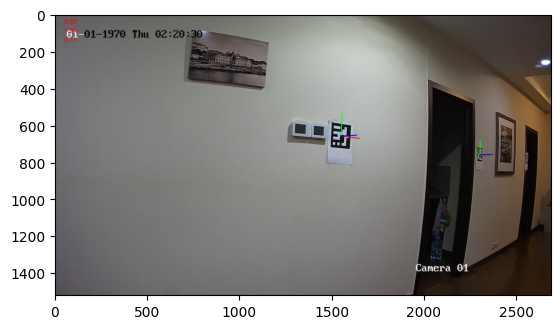

[[ 0.86009478  0.04089051  0.50849281  0.92102848]
 [ 0.50685652  0.04431468 -0.86089063  1.54094543]
 [-0.05773595  0.99818043  0.01738921  0.17464665]
 [ 0.          0.          0.          1.        ]]
319
before
det 1.0000000000000002
[[-0.1585385  -0.08053244 -0.98406304  2.18370031]
 [ 0.16107983 -0.98542477  0.05469294 -0.14415814]
 [-0.97412465 -0.14984178  0.16919992  3.15773146]
 [ 0.          0.          0.          1.        ]]
after
det 1.0000000000000002
[[-0.1585385  -0.08053244 -0.98406304  2.18370031]
 [ 0.16107983 -0.98542477  0.05469294 -0.14415814]
 [-0.97412465 -0.14984178  0.16919992  3.15773146]
 [ 0.          0.          0.          1.        ]]
before
det 1.0000000000000009
[[ 0.86857314  0.05590377  0.49239767  0.23755242]
 [ 0.0416044  -0.99833491  0.03995597 -0.2029633 ]
 [ 0.49381147 -0.01421877 -0.86945273  1.94473504]
 [ 0.          0.          0.          1.        ]]
after
det 1.0000000000000009
[[ 0.86857314  0.05590377  0.49239767  0.23755242]
 [ 0.04

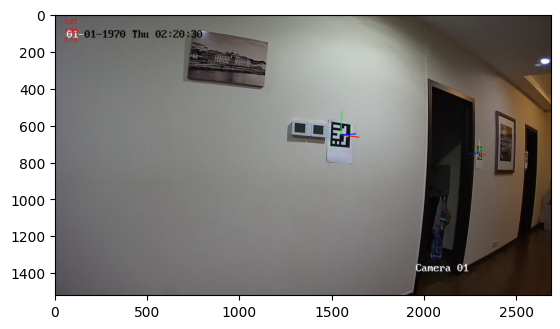

[[ 0.91615729  0.03654487  0.39914945  1.2721    ]
 [ 0.39556564  0.07826377 -0.91509705  1.5840148 ]
 [-0.06468104  0.99626264  0.05724603  0.15352615]
 [ 0.          0.          0.          1.        ]]


In [7]:
# Test on multiple images
for i in range(318,320):
    print(i)
    image = cv2.imread(f"../data/hikvision/demo1/frames_f/{i}.png")
    time.sleep(.1)
    
    # output = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # plt.imshow(output)
    # plt.show()
    
    frame, pose, dt, size = estimator(image, "now", True)
    
    output = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    try:
        output = display_pose(output, pose[:-1,[3]])
    except: continue
    plt.imshow(output)
    plt.show()
    print(pose)
    

In [5]:
frame.shape

(960, 1280, 3)

In [6]:
# Alter intrinsic matrix with resolutoin change
k_video = copy.deepcopy(k)
k_video[1,1] = k_video[1,1] * 720/960

# or

k_video = k

In [7]:
# np.save("camera_matrix_video.npy", k_video)

In [9]:
cap = cv2.VideoCapture('../data/hikvision/demo1/r.mp4')

In [10]:
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)/10)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

estimator_video = PoseSingle(
    aruco_dict_type,
    n_markers,
    marker_step,
    edge_len,
    k,
    d
)

out = cv2.VideoWriter('../data/results/hikvision_r_weighted_flip.mov', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (width,height))

In [11]:
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        frame, pose, dt, size = estimator_video(frame, "now", True)
        # print(type(pose))
        output = frame#cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # print(pose.shape==())
        if pose.shape!=():
            output = display_pose(output, pose[:-1,[3]])
        
        out.write(output)
  # Break the loop
    else: 
        break

cap.release()
out.release()

C:\Users\vmart\PycharmProjects\cranpos\core\campose.py:178: RuntimeWarning: invalid value encountered in divide
  right_x_weights /= sum(right_x_weights)


In [11]:
frame